VARMA is similar to an ARMA model that uses a system of equations with more than one related time-series data instead of a single time-series data. <BR>
Auto Regression + Moving Average

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'
sp = pd.read_csv('Data/PCEPersonalSpending.csv', index_col = 0, parse_dates=True)
sp.index.freq = 'MS'

In [4]:
df = df.join(sp)

In [5]:
# drop null values
df.dropna(inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1995-01-01 to 2015-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Money     252 non-null    float64
 1   Spending  252 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


In [7]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [8]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

# we use auto arima for VARMA
from pmdarima import auto_arima

<Axes: xlabel='Date'>

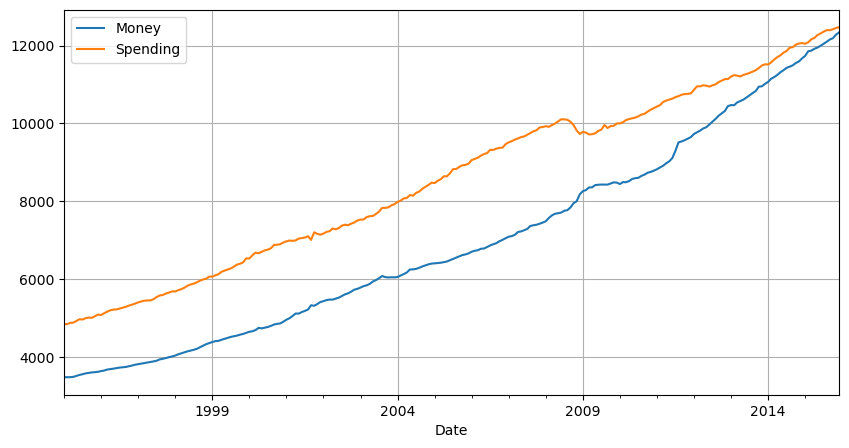

In [9]:
df.plot(figsize = (10, 5), grid = True, legend = True)

In [10]:
# function for generating ADF interpretation report
# we use this to check if the time-series data is stationary
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print('\nConclusion:')
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print('\nConclusion:')
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
adf_test(df['Money'])
print('\n')
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044

Conclusion:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019

Conclusion:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [13]:
auto_arima(df['Money'], maxiter = 1000)   # set maxiter to avoid warnings

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [14]:
auto_arima(df['Spending'], maxiter = 1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

From **auto_arima** results we need to perform differencing on the data. However, we can also see that the suggested value of **p = 1 and q = 2**.


In [15]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


### Train Test Split

In [16]:
# Num of observations
nobs = 12
train = df_transformed[:-nobs]    # start = begging of df --> go to -12 from the end
test = df_transformed[-nobs:]     # start from -12 and go to the end

In [17]:
model = VARMAX(train, order = (1, 2)).fit(maxiter = 1000, disp = False)
model.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2285.996
,+ intercept,AIC,4605.992
Date:,"Fri, 01 Sep 2023",BIC,4665.021
Time:,14:02:53,HQIC,4629.782
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.55, 0.00",Jarque-Bera (JB):,"551.52, 131.48"
Prob(Q):,"0.46, 0.99",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.62, 2.84",Skew:,"1.33, -0.32"


### Make Prediction

In [18]:
df_forecast = model.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.979393,37.695021
2015-02-01,-11.067992,-5.058121
2015-03-01,1.489826,-0.051479
2015-04-01,-1.758623,-0.452800
2015-05-01,1.142392,0.331663
2015-06-01,-0.466024,-0.044438
2015-07-01,0.561371,0.208886
2015-08-01,-0.064723,0.057036
2015-09-01,0.322642,0.151497
2015-10-01,0.084157,0.093443


### Invert Transformation

In [20]:
'''
To reverse the differencing we do the following:
1. Take a cumulative sum of the currently differentiated data
2. Take last (n) datapoints from the original training data (n = times differentiated) and subtract them
3. Add 2 to 1

'''

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [21]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [22]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.979393,37.695021,66.620607,11658.120607,48.295021,12099.695021
2015-02-01,-11.067992,-5.058121,55.552614,11647.052614,43.236900,12094.636900
2015-03-01,1.489826,-0.051479,57.042441,11648.542441,43.185420,12094.585420
2015-04-01,-1.758623,-0.452800,55.283818,11646.783818,42.732621,12094.132621
2015-05-01,1.142392,0.331663,56.426209,11647.926209,43.064284,12094.464284
2015-06-01,-0.466024,-0.044438,55.960185,11647.460185,43.019846,12094.419846
2015-07-01,0.561371,0.208886,56.521556,11648.021556,43.228732,12094.628732
2015-08-01,-0.064723,0.057036,56.456833,11647.956833,43.285768,12094.685768
2015-09-01,0.322642,0.151497,56.779475,11648.279475,43.437265,12094.837265
2015-10-01,0.084157,0.093443,56.863633,11648.363633,43.530708,12094.930708


### Plot Results

<Axes: xlabel='Date'>

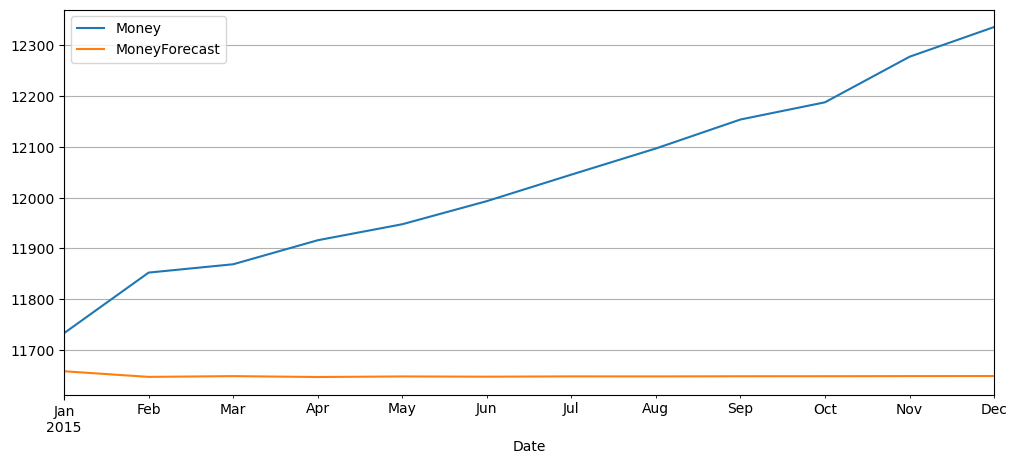

In [23]:
# plot money
df['Money'].iloc[-12:].plot(figsize = (12, 5), grid = True, legend= True)
df_forecast['MoneyForecast'].plot(figsize = (12, 5), grid = True, legend= True)

<Axes: xlabel='Date'>

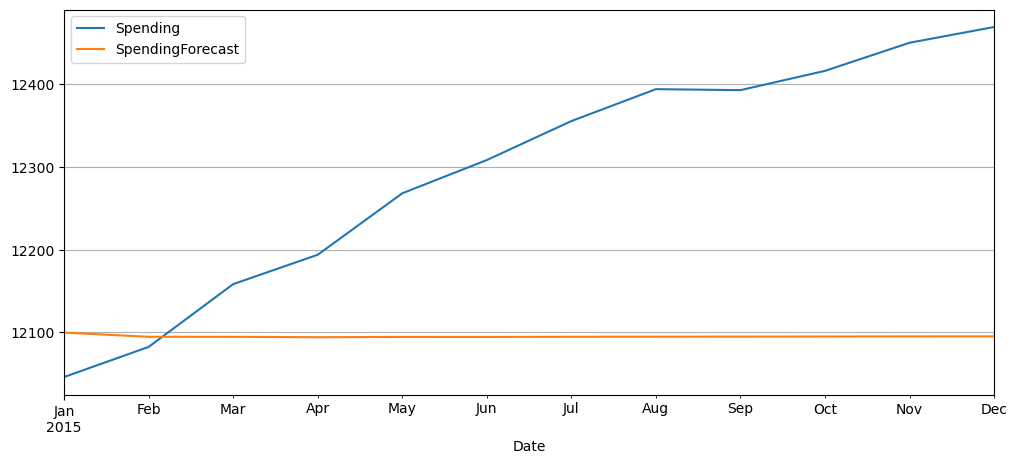

In [25]:
# plot money
df['Spending'].iloc[-12:].plot(figsize = (12, 5), grid = True, legend= True)
df_forecast['SpendingForecast'].plot(figsize = (12, 5), grid = True, legend= True)

We can see that the VARMA model is not performing that well in comparison to the VAR model. This means that the two time-series are not strongly related enough for VARMA to produce goos results.

### Calculate RMSE

In [26]:
rmse(df['Money'].iloc[-12:],df_forecast['MoneyForecast'])

423.4222138313686

In [27]:
rmse(df['Spending'].iloc[-12:],df_forecast['SpendingForecast'])

242.9542953224808

The RMSE error for VARMA is much higher compared to that of VAR model for which the error was in two digits.